In [1]:
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np

In [2]:
# სეისმური სადგურის მონაცემების მისაღები სერვერი
FDSN_CLIENT = Client("http://192.168.11.250:8080")
# მიწისძვრის დრო, რომელიც გადაეცემა როგორც არგუმენტი
ORIGIN_TIME = UTCDateTime("2025-03-08 11:28:25.120")
START_TIME = ORIGIN_TIME - 120  # 120 წამით ადრე
END_TIME = ORIGIN_TIME + 180  # 180 წამით გვიან
NETWORK = 'GO'
STATION = 'MTAG'
CHANNEL_ACC = 'HN*'
CHANNEL_VEL = "HH*"
G = 9.81

3 Trace(s) in Stream:
GO.MTAG.20.HNE | 2025-03-08T11:26:25.120000Z - 2025-03-08T11:31:25.120000Z | 200.0 Hz, 60001 samples
GO.MTAG.20.HNN | 2025-03-08T11:26:25.120000Z - 2025-03-08T11:31:25.120000Z | 200.0 Hz, 60001 samples
GO.MTAG.20.HNZ | 2025-03-08T11:26:25.120000Z - 2025-03-08T11:31:25.120000Z | 200.0 Hz, 60001 samples

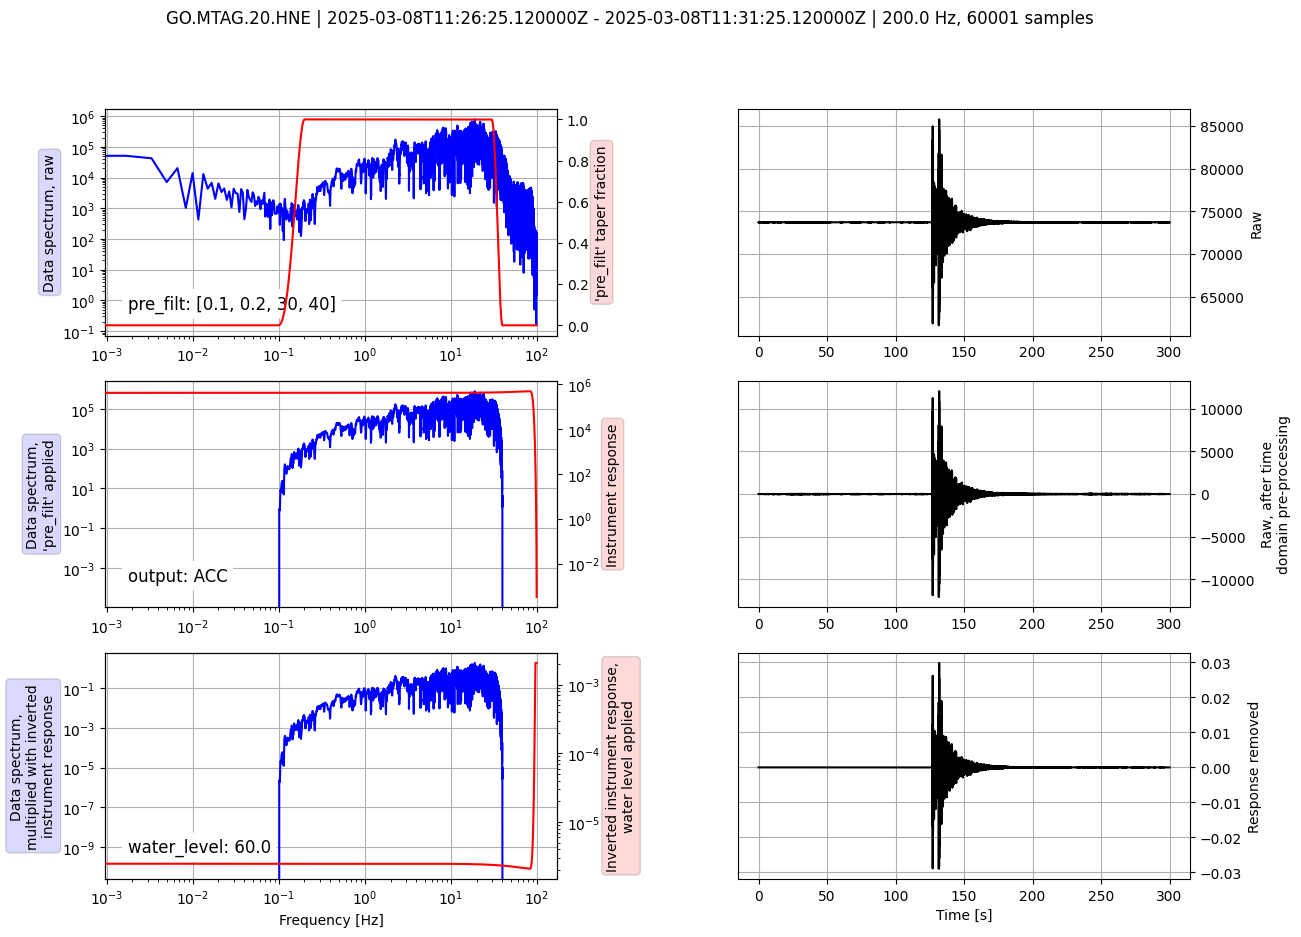

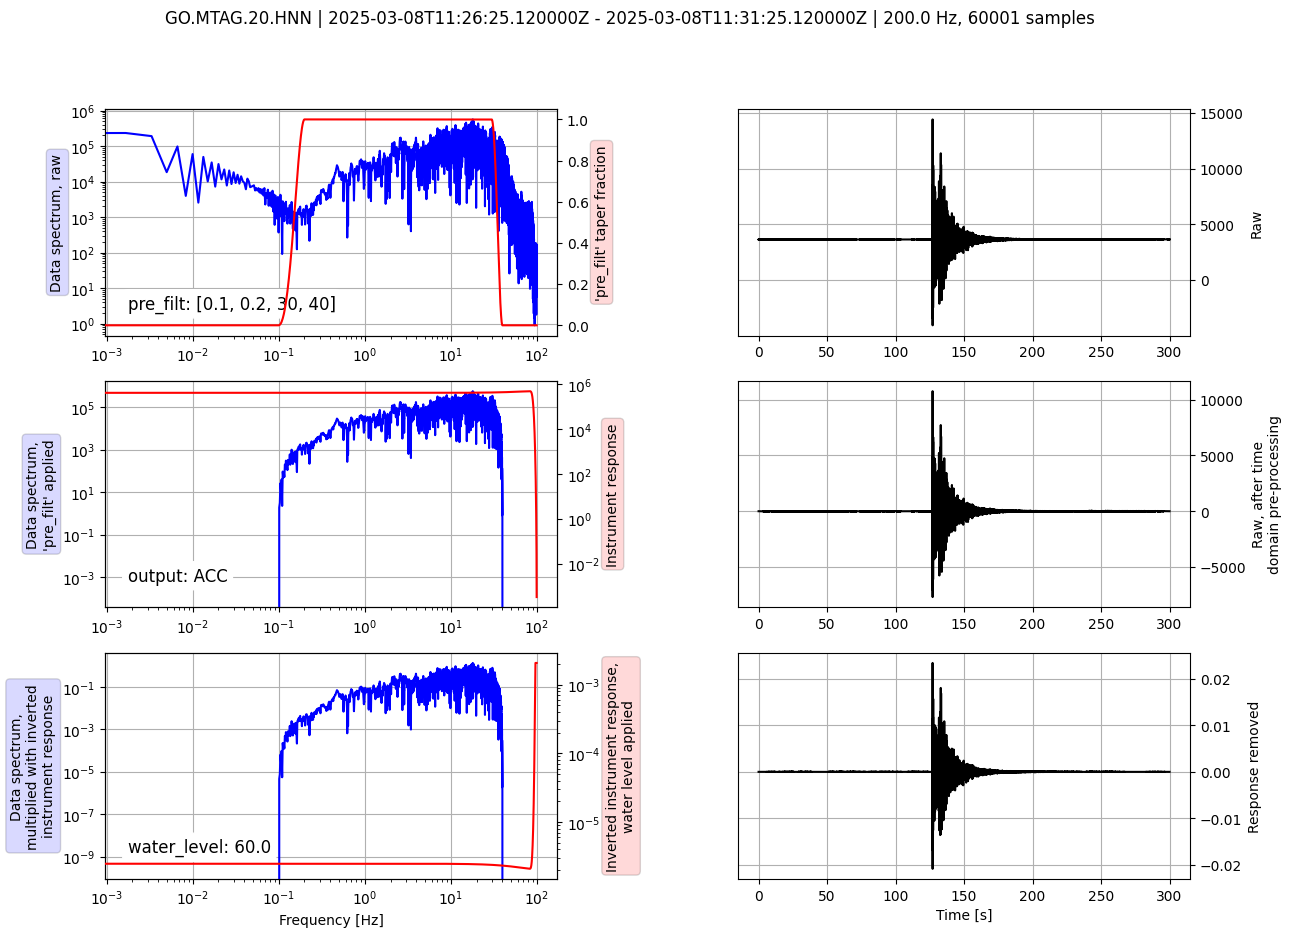

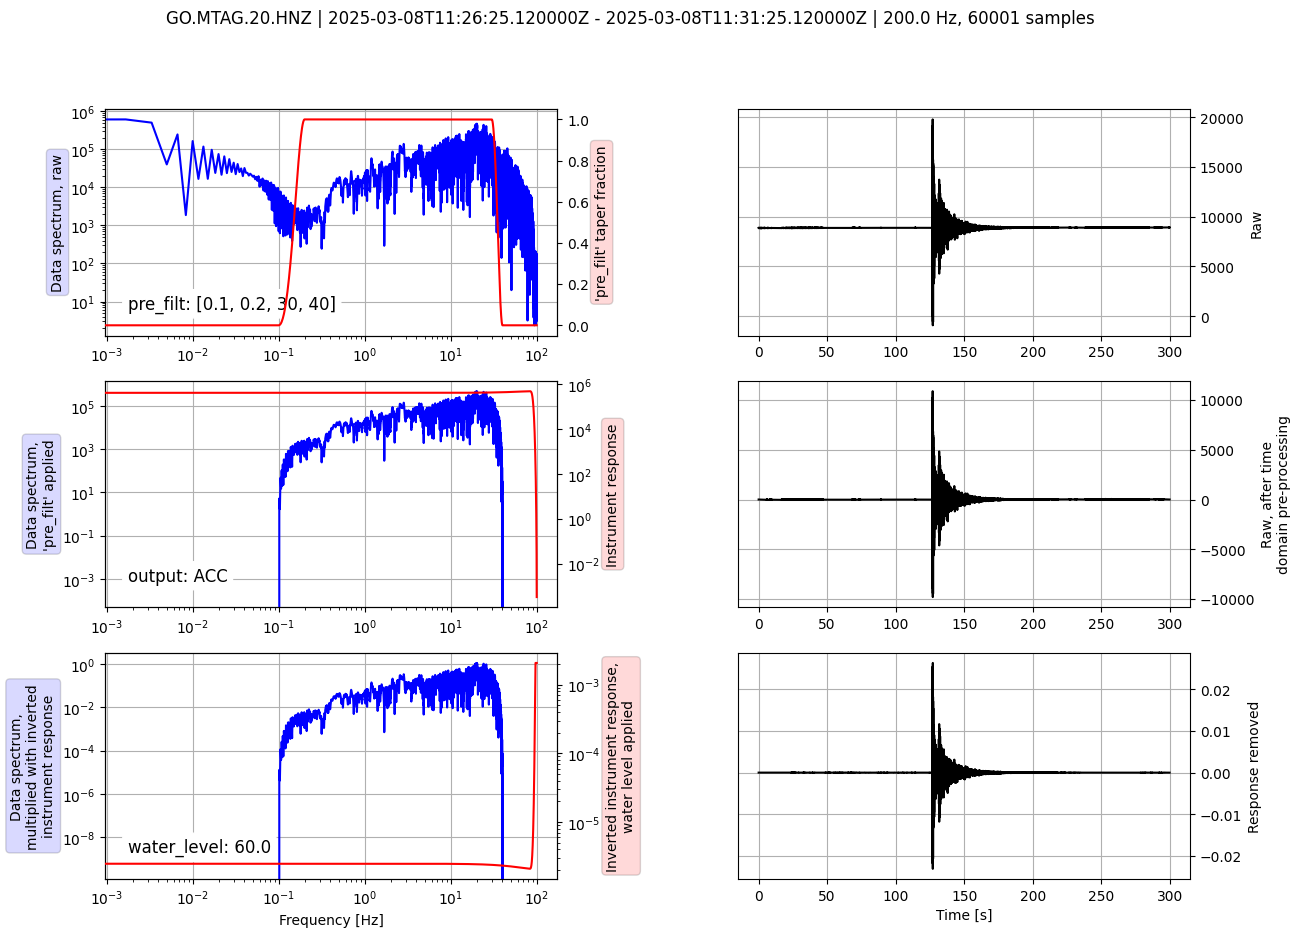

In [3]:
st_inventory = FDSN_CLIENT.get_stations(network=NETWORK, station=STATION, location='*', channel=CHANNEL_ACC, starttime=START_TIME, endtime=END_TIME, level="response")

# ვიღებთ ტალღის ფორმებს
st_stream = FDSN_CLIENT.get_waveforms(NETWORK, STATION, '*', CHANNEL_ACC, START_TIME, END_TIME)
# ვშლით ინსტრუმენტულ პასუხს (response) და ვცვლით ერთეულს
st_stream.remove_response(inventory=st_inventory, output="ACC", pre_filt=[0.1, 0.2, 30.0, 40.0], plot=True, zero_mean=True, water_level=60.0)
st_stream.filter(
    "bandpass",
    freqmin=1.0,
    freqmax=10.0,
    corners=4,
    zerophase=True
)

In [ ]:
# ვიღებთ არხების response-ით
inventory = FDSN_CLIENT.get_stations(network=NETWORK, station=STATION, channel=CHANNEL_VEL,
                                     starttime=START_TIME, endtime=END_TIME, level="response")
stream = FDSN_CLIENT.get_waveforms(network=NETWORK, station=STATION, location="*", channel=CHANNEL_VEL,
                                   starttime=START_TIME, endtime=END_TIME)


# ვშლით response-ს VEL-სთვის
stream.remove_response(inventory=inventory, output="VEL", zero_mean=True, taper=True)
stream.detrend("linear")
stream.detrend("demean")
stream.filter("bandpass", freqmin=1, freqmax=10, corners=4, zerophase=True, water_level=60.0)


# ვაგენერირებთ ACC
dt = stream[0].stats.delta
max_g_list = []

for tr in stream:
    acc = tr.differentiate()
    max_acc = np.max(np.abs(acc))
    max_g = max_acc / G
    max_g_list.append((tr.id, max_g))

# ვბეჭდავთ მაქსიმალურებს
for chan_id, max_g in max_g_list:
    print(f"{chan_id} -> PGA: {max_g:.6f} g")

GO.MTAG.00.HHE -> PGA: 0.000983 g
GO.MTAG.00.HHN -> PGA: 0.000477 g
GO.MTAG.00.HHZ -> PGA: 0.000460 g


In [5]:
for tr in st_stream:
    g_acc = tr.data / 9.81  # აჩქარების გადაყვანა g ერთეულში
    max_g = np.max(np.abs(g_acc))
    print(f'{tr.stats.channel} : {max_g:.6f} g')

HNE : 0.001115 g
HNN : 0.000513 g
HNZ : 0.000504 g


In [6]:
from obspy.signal.cross_correlation import correlate, xcorr_max

# Assume tr1 and tr2 have same sampling rate & aligned time windows
cc = correlate(tr.data, tr.data, shift=int(10 * tr.stats.sampling_rate))  # max shift = 10 s
shift, value = xcorr_max(cc)

print(f"Max correlation value: {value:.3f}")
print(f"Time shift (samples): {shift}")
print(f"Time shift (seconds): {shift * tr.stats.delta}")

Max correlation value: 1.000
Time shift (samples): 0
Time shift (seconds): 0.0


1 Trace(s) in Stream:
GO.EMLK.20.HNZ | 2024-12-28T11:41:59.460000Z - 2024-12-28T11:46:59.460000Z | 200.0 Hz, 60001 samples


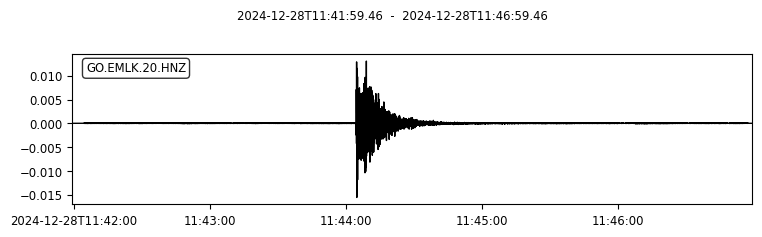

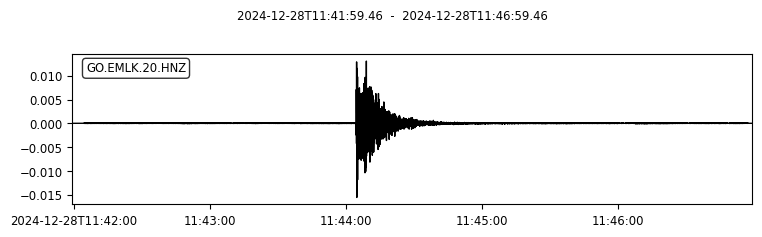

In [7]:
st = read("/home/sysop/Code/Acceleration_mseed/temp/2024/2024-12-28T11:43:59.460000Z/EMLK/2024-12-28T11:43:59.460000Z_GO_EMLK_HNZ.ascii")
print(st)
st.plot()